In [ ]:
!nvidia-smi

In [2]:
!pip install transformers datasets evaluate wandb --quiet

## Load Data and Libraries

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from transformers import ViTFeatureExtractor, ViTForImageClassification, AutoFeatureExtractor, ResNetForImageClassification
from transformers import TrainingArguments, Trainer
from datasets import load_metric, DatasetDict, Dataset, load_dataset

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image

import wandb
import numpy as np
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score

In [4]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
datasets = load_dataset('imagefolder', data_dir='../input/shoe-vs-sandal-vs-boot-dataset-15k-images/Shoe vs Sandal vs Boot Dataset')
datasets = datasets['train'].train_test_split(test_size=.2, seed=42)

datasets_split = datasets['train'].train_test_split(test_size=.2, seed=42)
datasets['train'] = datasets_split['train']
datasets['validation'] = datasets_split['test']

datasets

Resolving data files:   0%|          | 0/15000 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset image_folder downloaded and prepared to /root/.cache/huggingface/datasets/image_folder/default-cd2ee9f2e871a5f7/0.0.0/ee92df8e96c6907f3c851a987be3fd03d4b93b247e727b69a8e23ac94392a091. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 9600
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 3000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 2400
    })
})

In [6]:
labels = datasets['train'].features['label'].names
labels

['Boot', 'Sandal', 'Shoe']

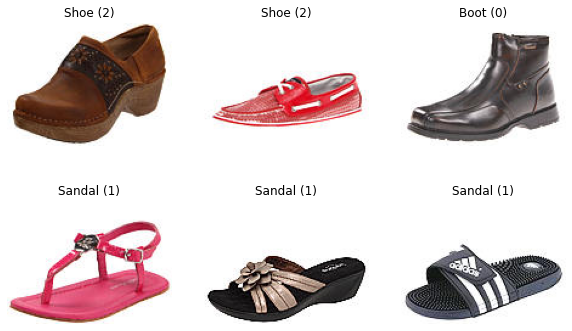

In [7]:
# plot samples
samples = datasets['train'].select(range(6))
pointer = 0

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10,6))
for i in range(2):
    for j in range(3):
        ax[i,j].imshow(samples[pointer]['image'])
        ax[i,j].set_title(f"{labels[samples[pointer]['label']]} ({samples[pointer]['label']})")
        ax[i,j].axis('off')
        pointer+=1

plt.show()

## ViT - Vision Transformer

In [8]:
model_ckpt = 'google/vit-base-patch16-224-in21k'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
extractor = ViTFeatureExtractor.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [10]:
extractor(samples[0]['image'], return_tensors='pt')
# there are a lot of ones bcs the background of imgs are white, so its normal

{'pixel_values': tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])}

In [14]:
def batch_transform(examples):
    # take a list of PIL images and turn into pixel values
    inputs = extractor([x for x in examples['image']], return_tensors='pt')
    # add the labels in
    inputs['label'] = examples['label']
    
    return inputs

In [12]:
transformed_data = datasets.with_transform(batch_transform)
transformed_data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 9600
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 3000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 2400
    })
})

In [10]:
# data collator
def collate_fn(examples):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in examples]),
        'labels': torch.tensor([x['label'] for x in examples])
    }

# metrics
metric = load_metric('accuracy')
def compute_metrics(p):
    labels = p.label_ids
    preds = p.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'f1': f1
    }
#     return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

### Zero-shot

In [14]:
model = ViTForImageClassification.from_pretrained(model_ckpt,
                                                 num_labels=len(labels),
                                                 id2label={str(i): c for i, c in enumerate(labels)},
                                                 label2id={c: str(i) for i, c in enumerate(labels)})
model = model.to(device)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
zero_loader = DataLoader(transformed_data['test'], batch_size=16)
zero_pred = []
for batch in tqdm(zero_loader):
    with torch.no_grad():        
        logits = model(batch['pixel_values'].to(device)).logits
        pred = logits.argmax(-1).cpu().detach().tolist()
        zero_pred += [labels[i] for i in pred]

  0%|          | 0/188 [00:00<?, ?it/s]

In [16]:
zero_true = [labels[i] for i in datasets['test']['label']]

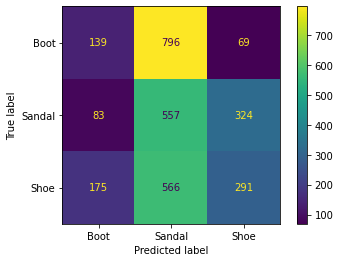

In [17]:
cm = confusion_matrix(zero_true, zero_pred, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()
plt.show()

In [18]:
print(f'ViT zero-shot Acc: {accuracy_score(zero_true, zero_pred):.3f}')
print(f'ViT zero-shot F1: {f1_score(zero_true, zero_pred, average="weighted"):.3f}')

ViT zero-shot Acc: 0.329
ViT zero-shot F1: 0.307


### Fine Tuning

In [19]:
vit_config = dict(learning_rate = 1e-5,
                  architecture = 'ViT',
                  dataset_id = 'shoe-sandal-boots',
                  infra='kaggle')

run = wandb.init(project='shoe-vs-sandals-vs-boots',
                notes='SMLT course project',
                tags=['comparison', 'ViT', 'ResNet'],                 
                config=vit_config,
                name='hf-ViT-base-16-224')

wandb: Currently logged in as: fhrzn. Use `wandb login --relogin` to force relogin


In [24]:
# train props
batch_size = 16
logging_steps = len(transformed_data['train']) // batch_size

In [21]:
training_args = TrainingArguments(output_dir='./kaggle/working/',
                                 report_to='wandb',
                                 per_device_train_batch_size=batch_size,
                                 per_device_eval_batch_size=batch_size,
                                 evaluation_strategy='epoch',
                                 save_strategy='epoch',
                                 num_train_epochs=3,
                                 fp16=True if torch.cuda.is_available() else False,
                                 logging_steps=logging_steps,
                                 learning_rate=1e-5,
                                 save_total_limit=2,
                                 remove_unused_columns=False,
                                 push_to_hub=False,
                                 load_best_model_at_end=True)

In [22]:
trainer = Trainer(model=model,
                 args=training_args,
                 data_collator=collate_fn,
                 compute_metrics=compute_metrics,
                 train_dataset=transformed_data['train'],
                 eval_dataset=transformed_data['validation'],
                 tokenizer=extractor)

Using cuda_amp half precision backend


In [23]:
train_result = trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9600
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1800
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.231400,0.068704,0.990417,0.990408
2,0.041400,0.053657,0.990000,0.990003
3,0.026700,0.043369,0.993333,0.993327


***** Running Evaluation *****
  Num examples = 2400
  Batch size = 16
Saving model checkpoint to ./kaggle/working/checkpoint-600
Configuration saved in ./kaggle/working/checkpoint-600/config.json
Model weights saved in ./kaggle/working/checkpoint-600/pytorch_model.bin
Feature extractor saved in ./kaggle/working/checkpoint-600/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 16
Saving model checkpoint to ./kaggle/working/checkpoint-1200
Configuration saved in ./kaggle/working/checkpoint-1200/config.json
Model weights saved in ./kaggle/working/checkpoint-1200/pytorch_model.bin
Feature extractor saved in ./kaggle/working/checkpoint-1200/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 16
Saving model checkpoint to ./kaggle/working/checkpoint-1800
Configuration saved in ./kaggle/working/checkpoint-1800/config.json
Model weights saved in ./kaggle/working/checkpoint-1800/pytorch_model.bin
Feature extract

In [24]:
trainer.evaluate(transformed_data['validation'])

***** Running Evaluation *****
  Num examples = 2400
  Batch size = 16


{'eval_loss': 0.04336903244256973,
 'eval_accuracy': 0.9933333333333333,
 'eval_f1': 0.9933272354443631,
 'eval_runtime': 25.2383,
 'eval_samples_per_second': 95.094,
 'eval_steps_per_second': 5.943,
 'epoch': 3.0}

In [25]:
predictions = trainer.predict(transformed_data['test'])
predictions.metrics

***** Running Prediction *****
  Num examples = 3000
  Batch size = 16


{'test_loss': 0.04060511291027069,
 'test_accuracy': 0.994,
 'test_f1': 0.9939998484491527,
 'test_runtime': 30.7084,
 'test_samples_per_second': 97.693,
 'test_steps_per_second': 6.122}

In [26]:
run.finish()

eval/accuracy,▂▁██
eval/f1,▂▁██
eval/loss,█▄▁▁
eval/runtime,▄▁▄█
eval/samples_per_second,▅█▅▁
eval/steps_per_second,▅█▅▁
train/epoch,▁▁▅▅████
train/global_step,▁▁▅▅████
train/learning_rate,█▅▁
train/loss,█▂▁
train/total_flos,▁


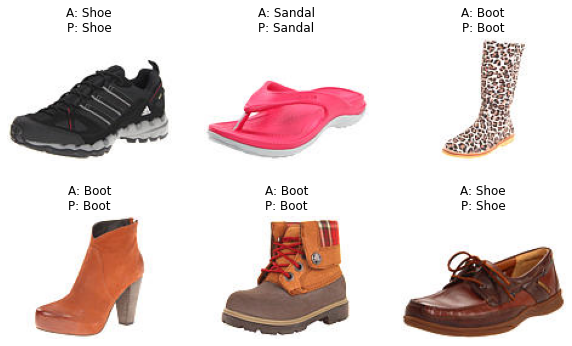

In [27]:
# plot samples
samples = datasets['test'].select(range(6))
pointer = 0

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10,6))
for i in range(2):
    for j in range(3):
        ax[i,j].imshow(samples[pointer]['image'])
        ax[i,j].set_title(f"A: {labels[samples[pointer]['label']]}\nP: {labels[predictions.label_ids[pointer]]}")
        ax[i,j].axis('off')
        pointer+=1

plt.show()

## ResNet152 - Residual Net

### Zero Shot

In [28]:
resnet_ckpt = 'microsoft/resnet-152'

In [29]:
extractor = AutoFeatureExtractor.from_pretrained(resnet_ckpt)
model = ResNetForImageClassification.from_pretrained(resnet_ckpt,
                                                    num_labels=len(labels),
                                                    id2label={str(i): c for i, c in enumerate(labels)},
                                                    label2id={c: str(i) for i, c in enumerate(labels)},
                                                    ignore_mismatched_sizes=True)

model = model.to(device)

https://huggingface.co/microsoft/resnet-152/resolve/main/preprocessor_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp915o7alr


Downloading:   0%|          | 0.00/266 [00:00<?, ?B/s]

storing https://huggingface.co/microsoft/resnet-152/resolve/main/preprocessor_config.json in cache at /root/.cache/huggingface/transformers/cd2a20d4cf84df03ab7603112e461ca596c6b632a1b9a82b866f434cb344a783.37be7274d6b5860aee104bb1fbaeb0722fec3850a85bb2557ae9491f17f89433
creating metadata file for /root/.cache/huggingface/transformers/cd2a20d4cf84df03ab7603112e461ca596c6b632a1b9a82b866f434cb344a783.37be7274d6b5860aee104bb1fbaeb0722fec3850a85bb2557ae9491f17f89433
loading feature extractor configuration file https://huggingface.co/microsoft/resnet-152/resolve/main/preprocessor_config.json from cache at /root/.cache/huggingface/transformers/cd2a20d4cf84df03ab7603112e461ca596c6b632a1b9a82b866f434cb344a783.37be7274d6b5860aee104bb1fbaeb0722fec3850a85bb2557ae9491f17f89433
Feature extractor ConvNextFeatureExtractor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ConvNextFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "i

Downloading:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

storing https://huggingface.co/microsoft/resnet-152/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/373b2ff9b5a0ff6371311629310b1824243860bc99d9fa810eea003a13dfaa45.aebe147cb4f0e0f9fec6fc4fd7187748151d106a85f04cc3c07832da007b2456
creating metadata file for /root/.cache/huggingface/transformers/373b2ff9b5a0ff6371311629310b1824243860bc99d9fa810eea003a13dfaa45.aebe147cb4f0e0f9fec6fc4fd7187748151d106a85f04cc3c07832da007b2456
loading configuration file https://huggingface.co/microsoft/resnet-152/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/373b2ff9b5a0ff6371311629310b1824243860bc99d9fa810eea003a13dfaa45.aebe147cb4f0e0f9fec6fc4fd7187748151d106a85f04cc3c07832da007b2456
Model config ResNetConfig {
  "architectures": [
    "ResNetForImageClassification"
  ],
  "depths": [
    3,
    8,
    36,
    3
  ],
  "downsample_in_first_stage": false,
  "embedding_size": 64,
  "hidden_act": "relu",
  "hidden_sizes": [
    256,
    512,
    1024,


Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

storing https://huggingface.co/microsoft/resnet-152/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/94e591fd2257f5287a034ee808898fce5a9e65f689fcb01a8a2b7f98ddc60120.bbd199fce9c651aa5d89f34688d4bfe21087b4ec88b2ed9fdb34cb05c1811e7f
creating metadata file for /root/.cache/huggingface/transformers/94e591fd2257f5287a034ee808898fce5a9e65f689fcb01a8a2b7f98ddc60120.bbd199fce9c651aa5d89f34688d4bfe21087b4ec88b2ed9fdb34cb05c1811e7f
loading weights file https://huggingface.co/microsoft/resnet-152/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/94e591fd2257f5287a034ee808898fce5a9e65f689fcb01a8a2b7f98ddc60120.bbd199fce9c651aa5d89f34688d4bfe21087b4ec88b2ed9fdb34cb05c1811e7f
All model checkpoint weights were used when initializing ResNetForImageClassification.

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-152 and are newly initialized because the shapes did not match:


In [54]:
transformed_data = datasets.with_transform(batch_transform)
transformed_data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 9600
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 3000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 2400
    })
})

In [31]:
zero_loader = DataLoader(transformed_data['test'], batch_size=16)
zero_pred = []
for batch in tqdm(zero_loader):
    with torch.no_grad():        
        logits = model(batch['pixel_values'].to(device)).logits
        pred = logits.argmax(-1).cpu().detach().tolist()
        zero_pred += [labels[i] for i in pred]

  0%|          | 0/188 [00:00<?, ?it/s]

In [32]:
zero_true = [labels[i] for i in datasets['test']['label']]

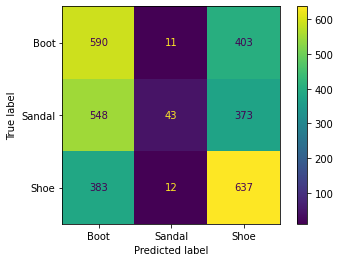

In [33]:
cm = confusion_matrix(zero_true, zero_pred, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()
plt.show()

In [34]:
print(f'ResNet152 zero-shot Acc: {accuracy_score(zero_true, zero_pred):.3f}')
print(f'ResNet152 zero-shot F1: {f1_score(zero_true, zero_pred, average="weighted"):.3f}')

ResNet152 zero-shot Acc: 0.423
ResNet152 zero-shot F1: 0.362


### Fine Tuning

In [35]:
resnet_config = dict(learning_rate = 1e-5,
                  architecture = 'ViT',
                  dataset_id = 'shoe-sandal-boots',
                  infra='kaggle')

run = wandb.init(project='shoe-vs-sandals-vs-boots',
                notes='SMLT course project',
                tags=['comparison', 'ViT', 'ResNet'],                 
                config=vit_config,
                name='hf-ResNet-152')

In [36]:
resnet_args = TrainingArguments(output_dir='./kaggle/working/',
                                 report_to='wandb',
                                 per_device_train_batch_size=batch_size,
                                 per_device_eval_batch_size=batch_size,
                                 evaluation_strategy='epoch',
                                 save_strategy='epoch',
                                 num_train_epochs=3,
                                 fp16=True if torch.cuda.is_available() else False,
                                 logging_steps=logging_steps,
                                 learning_rate=1e-5,
                                 save_total_limit=2,
                                 remove_unused_columns=False,
                                 push_to_hub=False,
                                 load_best_model_at_end=True,)

PyTorch: setting up devices


In [37]:
resnet_trainer = Trainer(model=model,
                 args=resnet_args,
                 data_collator=collate_fn,
                 compute_metrics=compute_metrics,
                 train_dataset=transformed_data['train'],
                 eval_dataset=transformed_data['validation'],
                 tokenizer=extractor)

Using cuda_amp half precision backend


In [38]:
resnet_trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9600
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1800
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.942100,0.701172,0.850000,0.847307
2,0.550600,0.415392,0.917083,0.917152
3,0.412600,0.353726,0.927500,0.927441


***** Running Evaluation *****
  Num examples = 2400
  Batch size = 16
Saving model checkpoint to ./kaggle/working/checkpoint-600
Configuration saved in ./kaggle/working/checkpoint-600/config.json
Model weights saved in ./kaggle/working/checkpoint-600/pytorch_model.bin
Feature extractor saved in ./kaggle/working/checkpoint-600/preprocessor_config.json
Deleting older checkpoint [kaggle/working/checkpoint-1200] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 16
Saving model checkpoint to ./kaggle/working/checkpoint-1200
Configuration saved in ./kaggle/working/checkpoint-1200/config.json
Model weights saved in ./kaggle/working/checkpoint-1200/pytorch_model.bin
Feature extractor saved in ./kaggle/working/checkpoint-1200/preprocessor_config.json
Deleting older checkpoint [kaggle/working/checkpoint-1800] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 16
Saving model checkpoint to ./kaggle/worki

TrainOutput(global_step=1800, training_loss=0.6351094139946831, metrics={'train_runtime': 695.058, 'train_samples_per_second': 41.435, 'train_steps_per_second': 2.59, 'total_flos': 1.512552342454272e+18, 'train_loss': 0.6351094139946831, 'epoch': 3.0})

In [55]:
resnet_trainer.evaluate(transformed_data['validation'])

***** Running Evaluation *****
  Num examples = 2400
  Batch size = 16


{'eval_loss': 0.3537263572216034,
 'eval_accuracy': 0.9275,
 'eval_f1': 0.9274409395967136,
 'eval_runtime': 20.1417,
 'eval_samples_per_second': 119.156,
 'eval_steps_per_second': 7.447,
 'epoch': 3.0}

In [56]:
predictions = resnet_trainer.predict(transformed_data['test'])
predictions.metrics

***** Running Prediction *****
  Num examples = 3000
  Batch size = 16


{'test_loss': 0.3591686189174652,
 'test_accuracy': 0.9276666666666666,
 'test_f1': 0.9277962734435634,
 'test_runtime': 24.8328,
 'test_samples_per_second': 120.808,
 'test_steps_per_second': 7.571}

In [41]:
run.finish()

eval/accuracy,▄▇█▁
eval/f1,▄▇█▁
eval/loss,█▂▁▆
eval/runtime,▂▁▁█
eval/samples_per_second,▇██▁
eval/steps_per_second,▇██▁
train/epoch,▁▁▅▅████
train/global_step,▁▁▅▅████
train/learning_rate,█▄▁
train/loss,█▃▁
train/total_flos,▁


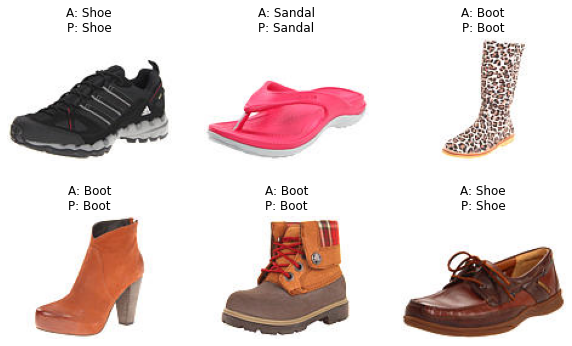

In [42]:
# plot samples
samples = datasets['test'].select(range(6))
pointer = 0

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10,6))
for i in range(2):
    for j in range(3):
        ax[i,j].imshow(samples[pointer]['image'])
        ax[i,j].set_title(f"A: {labels[samples[pointer]['label']]}\nP: {labels[predictions.label_ids[pointer]]}")
        ax[i,j].axis('off')
        pointer+=1

plt.show()

## ResNet50 - Residual Net

### Zero Shot

In [8]:
resnet50_ckpt = 'microsoft/resnet-50'

In [12]:
extractor = AutoFeatureExtractor.from_pretrained(resnet50_ckpt)
model = ResNetForImageClassification.from_pretrained(resnet50_ckpt,
                                                    num_labels=len(labels),
                                                    id2label={str(i): c for i, c in enumerate(labels)},
                                                    label2id={c: str(i) for i, c in enumerate(labels)},
                                                    ignore_mismatched_sizes=True)

model = model.to(device)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([3, 2048]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
transformed_data = datasets.with_transform(batch_transform)
transformed_data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 9600
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 3000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 2400
    })
})

In [16]:
zero_loader = DataLoader(transformed_data['test'], batch_size=16)
zero_pred = []
for batch in tqdm(zero_loader):
    with torch.no_grad():        
        logits = model(batch['pixel_values'].to(device)).logits
        pred = logits.argmax(-1).cpu().detach().tolist()
        zero_pred += [labels[i] for i in pred]

  0%|          | 0/188 [00:00<?, ?it/s]

In [17]:
zero_true = [labels[i] for i in datasets['test']['label']]

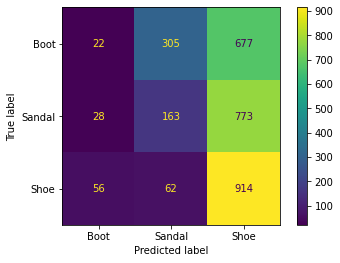

In [18]:
cm = confusion_matrix(zero_true, zero_pred, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()
plt.show()

In [19]:
print(f'ResNet50 zero-shot Acc: {accuracy_score(zero_true, zero_pred):.3f}')
print(f'ResNet50 zero-shot F1: {f1_score(zero_true, zero_pred, average="weighted"):.3f}')

ResNet50 zero-shot Acc: 0.366
ResNet50 zero-shot F1: 0.269


### Fine Tuning

In [20]:
resnet50_config = dict(learning_rate = 1e-5,
                  architecture = 'ResNet50',
                  dataset_id = 'shoe-sandal-boots',
                  infra='kaggle')

run = wandb.init(project='shoe-vs-sandals-vs-boots',
                notes='SMLT course project',
                tags=['comparison', 'ViT', 'ResNet'],                 
                config=resnet50_config,
                name='hf-ResNet-50')

wandb: Currently logged in as: fhrzn. Use `wandb login --relogin` to force relogin


In [25]:
resnet50_args = TrainingArguments(output_dir='./kaggle/working/',
                                 report_to='wandb',
                                 per_device_train_batch_size=batch_size,
                                 per_device_eval_batch_size=batch_size,
                                 evaluation_strategy='epoch',
                                 save_strategy='epoch',
                                 num_train_epochs=3,
                                 fp16=True if torch.cuda.is_available() else False,
                                 logging_steps=logging_steps,
                                 learning_rate=1e-5,
                                 save_total_limit=2,
                                 remove_unused_columns=False,
                                 push_to_hub=False,
                                 load_best_model_at_end=True,)

In [26]:
resnet50_trainer = Trainer(model=model,
                 args=resnet50_args,
                 data_collator=collate_fn,
                 compute_metrics=compute_metrics,
                 train_dataset=transformed_data['train'],
                 eval_dataset=transformed_data['validation'],
                 tokenizer=extractor)

Using cuda_amp half precision backend


In [27]:
resnet50_trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9600
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1800
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.053500,0.995908,0.740833,0.728703
2,0.923500,0.842979,0.793750,0.790014
3,0.825700,0.790364,0.800000,0.795797


***** Running Evaluation *****
  Num examples = 2400
  Batch size = 16
Saving model checkpoint to ./kaggle/working/checkpoint-600
Configuration saved in ./kaggle/working/checkpoint-600/config.json
Model weights saved in ./kaggle/working/checkpoint-600/pytorch_model.bin
Feature extractor saved in ./kaggle/working/checkpoint-600/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 16
Saving model checkpoint to ./kaggle/working/checkpoint-1200
Configuration saved in ./kaggle/working/checkpoint-1200/config.json
Model weights saved in ./kaggle/working/checkpoint-1200/pytorch_model.bin
Feature extractor saved in ./kaggle/working/checkpoint-1200/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 16
Saving model checkpoint to ./kaggle/working/checkpoint-1800
Configuration saved in ./kaggle/working/checkpoint-1800/config.json
Model weights saved in ./kaggle/working/checkpoint-1800/pytorch_model.bin
Feature extract

TrainOutput(global_step=1800, training_loss=0.9342385355631511, metrics={'train_runtime': 403.9323, 'train_samples_per_second': 71.299, 'train_steps_per_second': 4.456, 'total_flos': 6.116329157492736e+17, 'train_loss': 0.9342385355631511, 'epoch': 3.0})

In [28]:
resnet50_trainer.evaluate(transformed_data['validation'])

***** Running Evaluation *****
  Num examples = 2400
  Batch size = 16


{'eval_loss': 0.7903638482093811,
 'eval_accuracy': 0.8,
 'eval_f1': 0.7957967178945831,
 'eval_runtime': 16.3965,
 'eval_samples_per_second': 146.373,
 'eval_steps_per_second': 9.148,
 'epoch': 3.0}

In [29]:
predictions = resnet50_trainer.predict(transformed_data['test'])
predictions.metrics

***** Running Prediction *****
  Num examples = 3000
  Batch size = 16


{'test_loss': 0.7842972278594971,
 'test_accuracy': 0.8003333333333333,
 'test_f1': 0.7962167136994576,
 'test_runtime': 20.1202,
 'test_samples_per_second': 149.104,
 'test_steps_per_second': 9.344}

In [30]:
run.finish()

eval/accuracy,▁▇██
eval/f1,▁▇██
eval/loss,█▃▁▁
eval/runtime,▁▃▃█
eval/samples_per_second,█▆▆▁
eval/steps_per_second,█▆▆▁
train/epoch,▁▁▅▅████
train/global_step,▁▁▅▅████
train/learning_rate,█▅▁
train/loss,█▄▁
train/total_flos,▁


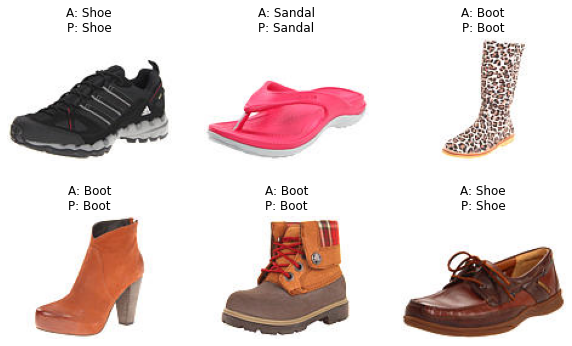

In [31]:
# plot samples
samples = datasets['test'].select(range(6))
pointer = 0

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10,6))
for i in range(2):
    for j in range(3):
        ax[i,j].imshow(samples[pointer]['image'])
        ax[i,j].set_title(f"A: {labels[samples[pointer]['label']]}\nP: {labels[predictions.label_ids[pointer]]}")
        ax[i,j].axis('off')
        pointer+=1

plt.show()